In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn import preprocessing
from collections import defaultdict
from collections import Counter

In [2]:
#import the train notebook
train1 = pd.read_csv('fraudTrain.csv')
print('Training Dataset:',train1.shape,'\n')
train1.head()

Training Dataset: (1296675, 23) 



,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
#print a list of the column names to start grouping them
train_heads = train1.columns.to_numpy()
train_heads.tolist()

['Unnamed: 0',
 'trans_date_trans_time',
 'cc_num',
 'merchant',
 'category',
 'amt',
 'first',
 'last',
 'gender',
 'street',
 'city',
 'state',
 'zip',
 'lat',
 'long',
 'city_pop',
 'job',
 'dob',
 'trans_num',
 'unix_time',
 'merch_lat',
 'merch_long',
 'is_fraud']

# Variable Grouping

## Identification Details -
* Cardholder Identifiers - 
    * Merge Columns `dob`, `first`, `last`, `gender`
    * `job`, `street`, `zip` & `cc_num` set as categorical variables
* Cardholder Vicinity -
    * Set `state` and `city` as categorical variables

## Transaction Details
* Transaction Timing Details related - `trans_date_trans_time` split into 
    * 1. `day` of the week as a Categorical Variable 
    * 2. `time` as a continuous series
* Transaction Type - 
    * `category`
    * `merchant`
* `city_state` and `city_pop` for comparison b/w city pop and fraud
* `amt` - shows spending patterns
* Use `lat`, `long`, `merch_lat`, `merch_long` to calculate distance between owner's residence and merchant

# Fraud Values
* `is_fraud` is the value to be predicted so it'll serve as the `y` value for the modelling

# 

In [4]:
#set features as categorical
train1[['state','city','job','cc_num','street','zip','merchant','category','trans_num']] = train1[['state','city','job','cc_num','street','zip','merchant','category','trans_num']].astype('category')

In [5]:
# merging columns into single string containing all personal info of the cardholder

train1['identifiers'] = train1[['first','last','gender','dob']].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)

#set to category
train1['identifiers'] = train1['identifiers'].astype('category')

#drop columns which were merged
train1 = train1.drop(columns = ['first','last','gender','dob'])
train1.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,street,city,state,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud,identifiers
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,"Jennifer,Banks,F,1988-03-09"
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,"Stephanie,Gill,F,1978-06-21"
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,"Edward,Sanchez,M,1962-01-19"
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,"Jeremy,White,M,1967-01-12"
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,"Tyler,Garcia,M,1986-03-28"


# 

### transaction `day` & `time`

In [6]:
def daycalc(a):
    array = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','Monday']
    return array[a]

In [7]:
#set to datetime and get day index
train1['date_time'] = pd.to_datetime(train1['trans_date_trans_time'])

train1['day'] = train1['date_time'].dt.dayofweek
train1['day_of_the_week'] = train1['day'].apply(daycalc)
train1['day_of_the_week'] = train1['day_of_the_week'].astype('category')

# convert from nanoseconds to gigaseconds to reduce the impact of each time stamp on the models used later
train1['time1'] = train1['date_time'].dt.time
train1['time1'] = train1['date_time'].apply(lambda x: x.value)
train1['time'] = train1['time1'].divide(10**18)

#drop columns
train1 = train1.drop(columns = ['trans_date_trans_time','unix_time','time1','day','date_time'])
train1.head()

,Unnamed: 0,cc_num,merchant,category,amt,street,city,state,zip,lat,long,city_pop,job,trans_num,merch_lat,merch_long,is_fraud,identifiers,day_of_the_week,time
0,0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",0b242abb623afc578575680df30655b9,36.011293,-82.048315,0,"Jennifer,Banks,F,1988-03-09",Tuesday,1.546301
1,1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1f76529f8574734946361c461b024d99,49.159047,-118.186462,0,"Stephanie,Gill,F,1978-06-21",Tuesday,1.546301
2,2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,a1a22d70485983eac12b5b88dad1cf95,43.150704,-112.154481,0,"Edward,Sanchez,M,1962-01-19",Tuesday,1.546301
3,3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,6b849c168bdad6f867558c3793159a81,47.034331,-112.561071,0,"Jeremy,White,M,1967-01-12",Tuesday,1.546301
4,4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,a41d7549acf90789359a9aa5346dcb46,38.674999,-78.632459,0,"Tyler,Garcia,M,1986-03-28",Tuesday,1.546301


# 

### `distance`

In [8]:
import geopy.distance #import geopy to enable coordinate based calculations

#create a function to group coordinates so that they can be used by the geopy function
def dist_calc(row):
    owner_coords = (row['lat'], row['long'])
    merch_coords = (row['merch_lat'], row['merch_long'])
    return geopy.distance.geodesic(owner_coords, merch_coords).km #returns distance between owner and merchant in kilometers

#applying the function
train1['distance'] = train1.apply(dist_calc, axis=1)

#drop columns
train1 = train1.drop(columns = ['lat','long','merch_lat','merch_long'])

train1.head()

,Unnamed: 0,cc_num,merchant,category,amt,street,city,state,zip,city_pop,job,trans_num,is_fraud,identifiers,day_of_the_week,time,distance
0,0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,561 Perry Cove,Moravian Falls,NC,28654,3495,"Psychologist, counselling",0b242abb623afc578575680df30655b9,0,"Jennifer,Banks,F,1988-03-09",Tuesday,1.546301,78.773821
1,1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,43039 Riley Greens Suite 393,Orient,WA,99160,149,Special educational needs teacher,1f76529f8574734946361c461b024d99,0,"Stephanie,Gill,F,1978-06-21",Tuesday,1.546301,30.216618
2,2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,594 White Dale Suite 530,Malad City,ID,83252,4154,Nature conservation officer,a1a22d70485983eac12b5b88dad1cf95,0,"Edward,Sanchez,M,1962-01-19",Tuesday,1.546301,108.102912
3,3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,9443 Cynthia Court Apt. 038,Boulder,MT,59632,1939,Patent attorney,6b849c168bdad6f867558c3793159a81,0,"Jeremy,White,M,1967-01-12",Tuesday,1.546301,95.685115
4,4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,408 Bradley Rest,Doe Hill,VA,24433,99,Dance movement psychotherapist,a41d7549acf90789359a9aa5346dcb46,0,"Tyler,Garcia,M,1986-03-28",Tuesday,1.546301,77.702395


In [9]:
train1 = train1.drop(columns = 'trans_num')

# Replicating the same process for the `Test` dataset before encoding

In [10]:
test1 = pd.read_csv('fraudTest.csv')
print('Testing Dataset:',test1.shape,'\n')

test1[['state','city','job','cc_num','street','zip','merchant','category','trans_num']] = test1[['state','city','job','cc_num','street','zip','merchant','category','trans_num']].astype('category')
test1['identifiers'] = test1[['first','last','gender','dob']].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)

#set to category
test1['identifiers'] = test1['identifiers'].astype('category')

#drop columns which were merged
test1 = test1.drop(columns = ['first','last','gender','dob'])
#set to datetime and get day index
test1['date_time'] = pd.to_datetime(test1['trans_date_trans_time'])

test1['day'] = test1['date_time'].dt.dayofweek
test1['day_of_the_week'] = test1['day'].apply(daycalc)
test1['day_of_the_week'] = test1['day_of_the_week'].astype('category')

# convert from nanoseconds to gigaseconds to reduce the impact of each time stamp on the models used later
test1['time1'] = test1['date_time'].dt.time
test1['time1'] = test1['date_time'].apply(lambda x: x.value)
test1['time'] = test1['time1'].divide(10**18)

#drop columns
test1 = test1.drop(columns = ['trans_date_trans_time','unix_time','time1','day','date_time'])
#applying the function
test1['distance'] = test1.apply(dist_calc, axis=1)

#drop columns
test1 = test1.drop(columns = ['lat','long','merch_lat','merch_long'])
test1 = test1.drop(columns = 'trans_num')

test1.head()

Testing Dataset: (555719, 23) 



,Unnamed: 0,cc_num,merchant,category,amt,street,city,state,zip,city_pop,job,is_fraud,identifiers,day_of_the_week,time,distance
0,0,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,351 Darlene Green,Columbia,SC,29209,333497,Mechanical engineer,0,"Jeff,Elliott,M,1968-03-19",Sunday,1.592742,24.613746
1,1,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,3638 Marsh Union,Altonah,UT,84002,302,"Sales professional, IT",0,"Joanne,Williams,F,1990-01-17",Sunday,1.592742,104.834043
2,2,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,9333 Valentine Point,Bellmore,NY,11710,34496,"Librarian, public",0,"Ashley,Lopez,F,1970-10-21",Sunday,1.592742,59.204796
3,3,3591919803438423,fraud_Haley Group,misc_pos,60.05,32941 Krystal Mill Apt. 552,Titusville,FL,32780,54767,Set designer,0,"Brian,Williams,M,1987-07-25",Sunday,1.592742,27.615117
4,4,3526826139003047,fraud_Johnston-Casper,travel,3.19,5783 Evan Roads Apt. 465,Falmouth,MI,49632,1126,Furniture designer,0,"Nathan,Massey,M,1955-07-06",Sunday,1.592742,104.423175


In [11]:
test1 = test1.drop(columns = 'Unnamed: 0')

## Reviewing the data

In [12]:
train1.dtypes

Unnamed: 0            int64
cc_num             category
merchant           category
category           category
amt                 float64
street             category
city               category
state              category
zip                category
city_pop              int64
job                category
is_fraud              int64
identifiers        category
day_of_the_week    category
time                float64
distance            float64
dtype: object

In [13]:
# check for any null within training dataset
train1.isna().sum().sum()

0

In [14]:
test1.dtypes

cc_num             category
merchant           category
category           category
amt                 float64
street             category
city               category
state              category
zip                category
city_pop              int64
job                category
is_fraud              int64
identifiers        category
day_of_the_week    category
time                float64
distance            float64
dtype: object

In [15]:
#check for any nulls within test dataset
test1.isna().sum().sum()

0

In [16]:
train1_cat = train1.select_dtypes('category')
test1_cat = test1.select_dtypes('category')
train1_cat.head()

,cc_num,merchant,category,street,city,state,zip,job,identifiers,day_of_the_week
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,561 Perry Cove,Moravian Falls,NC,28654,"Psychologist, counselling","Jennifer,Banks,F,1988-03-09",Tuesday
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,43039 Riley Greens Suite 393,Orient,WA,99160,Special educational needs teacher,"Stephanie,Gill,F,1978-06-21",Tuesday
2,38859492057661,fraud_Lind-Buckridge,entertainment,594 White Dale Suite 530,Malad City,ID,83252,Nature conservation officer,"Edward,Sanchez,M,1962-01-19",Tuesday
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,9443 Cynthia Court Apt. 038,Boulder,MT,59632,Patent attorney,"Jeremy,White,M,1967-01-12",Tuesday
4,375534208663984,fraud_Keeling-Crist,misc_pos,408 Bradley Rest,Doe Hill,VA,24433,Dance movement psychotherapist,"Tyler,Garcia,M,1986-03-28",Tuesday


In [17]:
#count unique
train1_cat.nunique()

cc_num             983
merchant           693
category            14
street             983
city               894
state               51
zip                970
job                494
identifiers        983
day_of_the_week      7
dtype: int64

In [18]:
test1_cat.head()

,cc_num,merchant,category,street,city,state,zip,job,identifiers,day_of_the_week
0,2291163933867244,fraud_Kirlin and Sons,personal_care,351 Darlene Green,Columbia,SC,29209,Mechanical engineer,"Jeff,Elliott,M,1968-03-19",Sunday
1,3573030041201292,fraud_Sporer-Keebler,personal_care,3638 Marsh Union,Altonah,UT,84002,"Sales professional, IT","Joanne,Williams,F,1990-01-17",Sunday
2,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,9333 Valentine Point,Bellmore,NY,11710,"Librarian, public","Ashley,Lopez,F,1970-10-21",Sunday
3,3591919803438423,fraud_Haley Group,misc_pos,32941 Krystal Mill Apt. 552,Titusville,FL,32780,Set designer,"Brian,Williams,M,1987-07-25",Sunday
4,3526826139003047,fraud_Johnston-Casper,travel,5783 Evan Roads Apt. 465,Falmouth,MI,49632,Furniture designer,"Nathan,Massey,M,1955-07-06",Sunday


In [19]:
#dropping day of the week since we already have day in an ordinal form
train1_cat = train1_cat.drop(columns = 'day_of_the_week')
test1_cat = test1_cat.drop(columns = 'day_of_the_week')

# Encoding variables

In [20]:
fraud_train = pd.DataFrame(train1[['is_fraud']])
fraud_test = pd.DataFrame(test1[['is_fraud']])

In [21]:
from category_encoders.cat_boost import CatBoostEncoder
cbe_encoder = CatBoostEncoder()
cbe_encoder.fit(train1_cat, fraud_train)
cbe_train = cbe_encoder.transform(train1_cat)
cbe_test = cbe_encoder.transform(test1_cat)

In [22]:
%%time
from category_encoders.binary import BinaryEncoder
bi_coder = BinaryEncoder()
bi_coder.fit(train1_cat, fraud_train)
bi_train = bi_coder.transform(train1_cat)
bi_test = bi_coder.transform(test1_cat)

CPU times: total: 9.8 s
Wall time: 9.82 s


In [23]:
train1_non_cat = train1.select_dtypes(exclude = 'category')
train1_non_cat = train1_non_cat.drop(columns = 'Unnamed: 0')

In [24]:
test1_non_cat = test1.select_dtypes(exclude = 'category')

In [25]:
test_binary = pd.concat([test1_non_cat,bi_test,fraud_test], axis = 1)
test_cbe = pd.concat([test1_non_cat,cbe_test,fraud_test], axis = 1)

In [26]:
test_binary = test_binary.sample(frac = 0.5, random_state = 1015)
test_cbe = test_cbe.sample(frac = 0.5, random_state = 1015)

## SMOTE won't be performed on test data
### Test data exported to csv directly

In [27]:
%%time
test_binary.to_csv('test_binary.csv')
test_cbe.to_csv('test_cbe.csv')

CPU times: total: 5.88 s
Wall time: 5.87 s


## 

# `Balancing` and `Sampling` the Training Data

In [28]:
X_train_cbe = pd.concat([train1_non_cat,cbe_train], axis = 1)
X_train_binary = pd.concat([train1_non_cat, bi_train], axis = 1)

In [29]:
X_train_cbe = X_train_cbe.sample(frac = 0.5, random_state = 1015)
X_train_binary = X_train_binary.sample(frac = 0.5, random_state = 1015)

In [30]:
y = fraud_train.sample(frac = 0.5, random_state = 1015)

In [31]:
%%time
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

osample1 = SMOTE(random_state = 1015)
osample2 = SMOTETomek(random_state = 1015)
osample3 = SMOTEENN(random_state = 1015)

#codes used here for X and Y are as follows:
#1_1 : cbe_SMOTE
#1_2 : cbe_SMOTETOMEK
#1_3 : cbe_SMOTEENN
#2_1 : binary_SMOTE
#2_2 : binary_SMOTETOMEK
#2_3 : binary_SMOTEENN

X_1_1, y_1_1 = osample1.fit_resample(X_train_cbe, y)
X_2_1, y_2_1 = osample1.fit_resample(X_train_binary, y)
X_1_3, y_1_3 = osample3.fit_resample(X_train_cbe, y)

CPU times: total: 30.5 s
Wall time: 29.1 s


* %%time
* X_1_2, y_1_2 = osample2.fit_resample(X_train_cbe, y)
* X_2_2, y_2_2 = osample2.fit_resample(X_train_binary, y)
* X__2_3, y_2_3 = osample3.fit_resample(X_train_binary, y)
SMOTETomek ran for far too long, hence we chose to exclude this sampling method

##### 

In [35]:
cbe_SMOTE_train = pd.concat([X_1_1, y_1_1], axis = 1)
#cbe_SMOTETomek_train = pd.concat([X_1_2, y_1_2], axis = 1)
cbe_SMOTEENN_train = pd.concat([X_1_3, y_1_3], axis = 1)

binary_SMOTE_train = pd.concat([X_2_1, y_2_1], axis = 1)
#binary_SMOTETomek_train = pd.concat([X_2_2, y_2_2], axis = 1)
# binary_SMOTEENN_train = pd.concat([X__2_3, y_2_3], axis = 1)

In [36]:
%%time
cbe_SMOTE_train.to_csv('cbe_SMOTE_train.csv')
cbe_SMOTEENN_train.to_csv('cbe_SMOTEENN_train.csv')
binary_SMOTE_train.to_csv('binary_SMOTE_train.csv')
# binary_SMOTEENN_train.to_csv('binary_SMOTEENN_train.csv')

CPU times: total: 43.3 s
Wall time: 43.4 s


[Text(0.5, 0, 'SMOTE, Binary Encoded')]

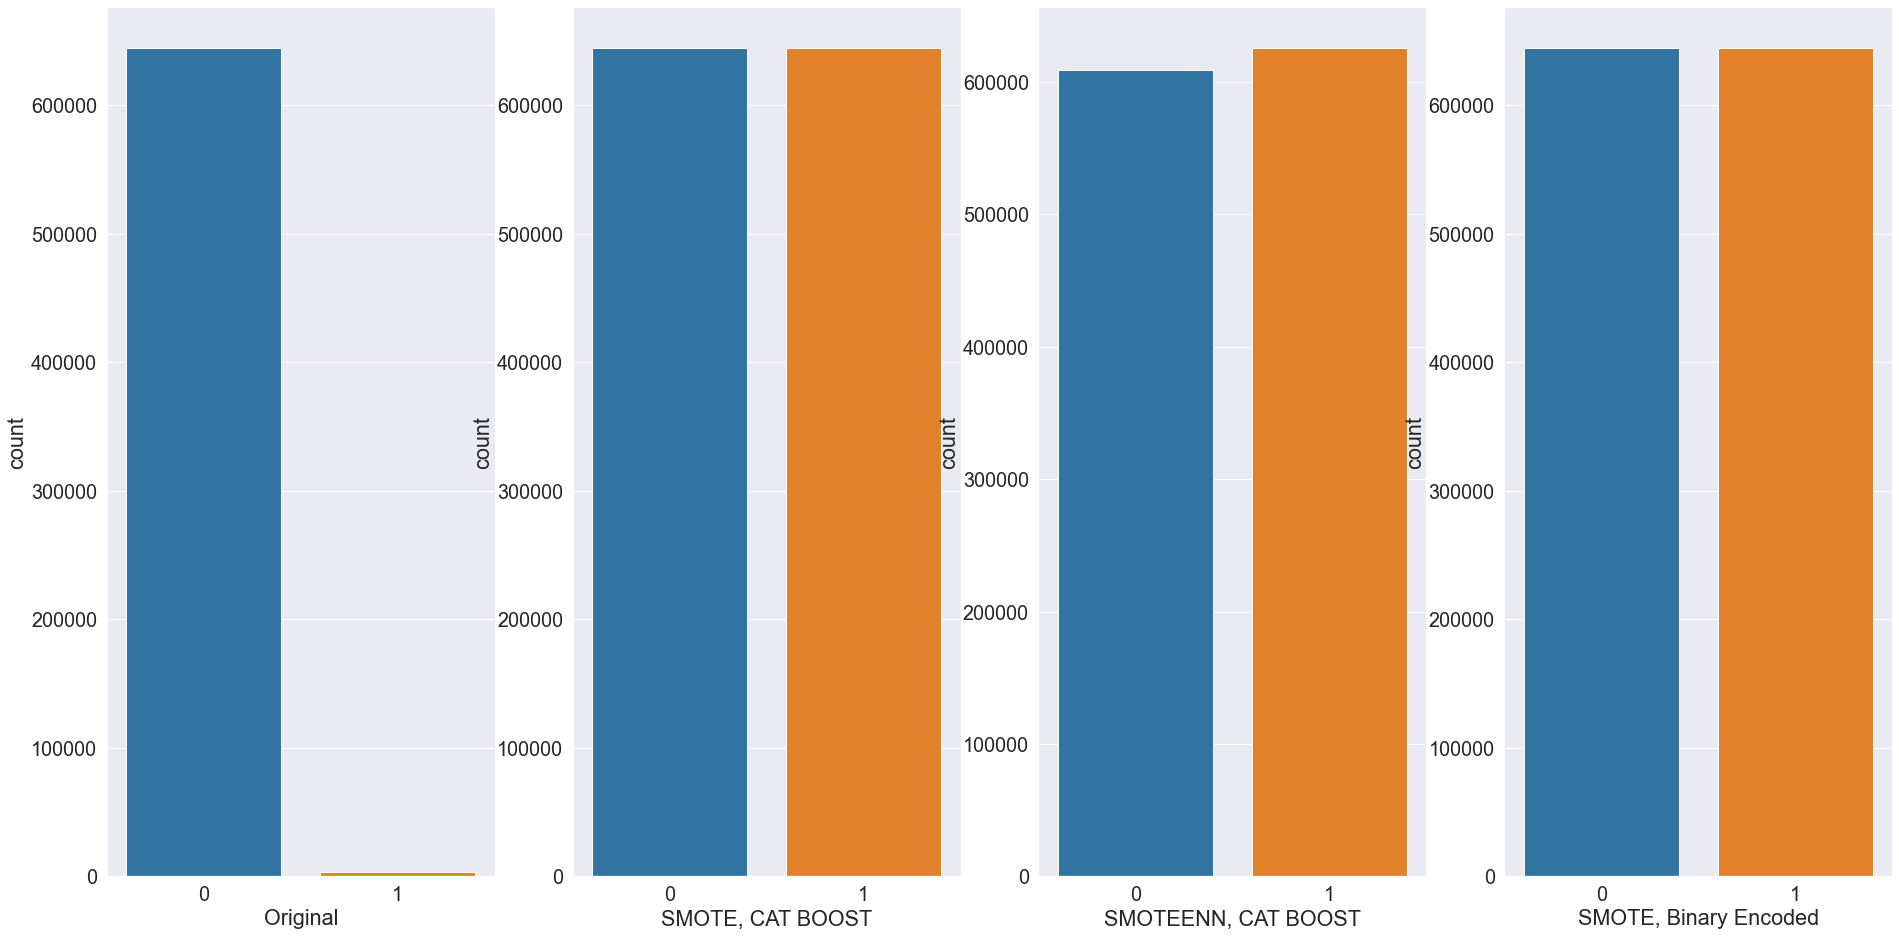

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.8) 
fig, axes =plt.subplots(1,4,figsize=(32,16))
sns.countplot(x = y['is_fraud'], ax = axes[0]).set(xlabel = "Original")
sns.countplot(x = y_1_1['is_fraud'], ax = axes[1]).set(xlabel = "SMOTE, CAT BOOST")
sns.countplot(x = y_1_3['is_fraud'], ax = axes[2]).set(xlabel = "SMOTEENN, CAT BOOST") 
sns.countplot(x = y_2_1['is_fraud'], ax = axes[3]).set(xlabel = "SMOTE, Binary Encoded")

# 